In [ ]:
# IMPORTING LIBRARIES
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
#uploading the dataset
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle_3m"

IMG_HEIGHT, IMG_WIDTH = 96 , 96
BATCH_SIZE = 8
SEED = 42


In [ ]:
!pip install tifffile


✅ Loaded 3189 image-mask pairs.
Image shape: (3189, 96, 96, 3)
Mask shape: (3189, 96, 96, 1)


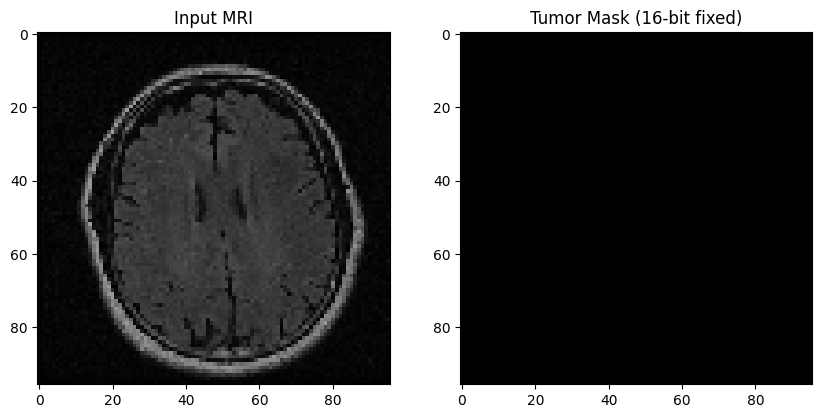

Mask stats → min: 0.0 max: 0.0 mean: 0.0


In [ ]:
import os
import numpy as np
import tifffile as tiff
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

IMG_HEIGHT, IMG_WIDTH = 96, 96

def load_data_from_nested_dirs(base_dir):
    images, masks = [], []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]
        mask_files = [f for f in files if "_mask" in f]

        for mask_file in mask_files:
            img_file = mask_file.replace("_mask", "")
            img_path = os.path.join(folder_path, img_file)
            mask_path = os.path.join(folder_path, mask_file)

            if not os.path.exists(img_path):
                continue

            # Load image normally
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img) / 255.0

            # Load 16-bit mask correctly
            mask = tiff.imread(mask_path).astype(np.float32)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

            # Normalize based on actual range (16-bit → 0–65535)
            if mask.max() > 0:
                mask = mask / mask.max()
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load using tifffile
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle_3m"
X, y = load_data_from_nested_dirs(BASE_DIR)

print(f"✅ Loaded {len(X)} image-mask pairs.")
print("Image shape:", X.shape)
print("Mask shape:", y.shape)

# ---- Visualize one ----
i = np.random.randint(0, len(X))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(X[i])
plt.title("Input MRI")
plt.subplot(1,2,2)
plt.imshow(y[i].squeeze(), cmap='gray')
plt.title("Tumor Mask (16-bit fixed)")
plt.show()

print("Mask stats → min:", y[i].min(), "max:", y[i].max(), "mean:", y[i].mean())


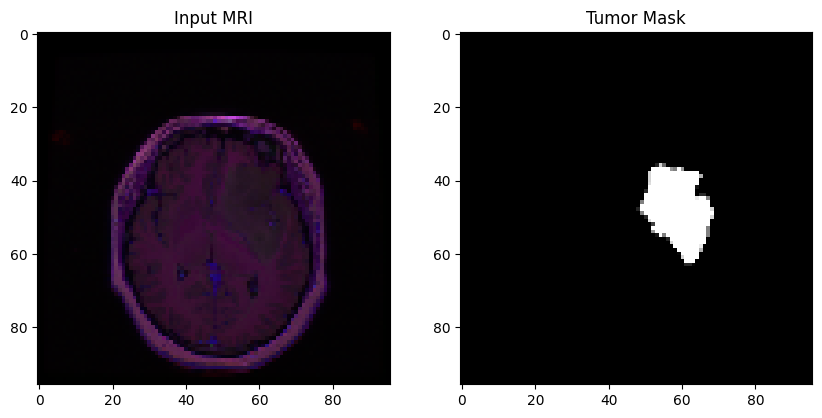

Mask stats → min: 0.0 max: 1.0 mean: 0.037073206


In [ ]:
import random
import matplotlib.pyplot as plt

i = random.randint(0, len(X)-1)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(X[i])
plt.title("Input MRI")

plt.subplot(1,2,2)
plt.imshow(y[i].squeeze(), cmap='gray')
plt.title("Tumor Mask")

plt.show()

print("Mask stats → min:", y[i].min(), "max:", y[i].max(), "mean:", y[i].mean())

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Training samples: 2551
Validation samples: 638


In [ ]:
def unet_model(input_size=(96,96,3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 96, 96,    │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 96, 96,    │      2,320 │ conv2d_38[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 48, 48,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 48, 48,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 48, 48,    │      9,248 │ conv2d_40[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 24, 24,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 12, 12,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 12, 12,    │    147,584 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 128) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 6, 6, 256) │    295,168 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 6, 6, 256) │    590,080 │ conv2d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 12, 12,    │    131,200 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 12, 12,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9852 - loss: 0.1315

319/319 ━━━━━━━━━━━━━━━━━━━━ 270s 817ms/step - accuracy: 0.9852 - loss: 0.1312 - val_accuracy: 0.9911 - val_loss: 0.0264
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9907 - loss: 0.0274

319/319 ━━━━━━━━━━━━━━━━━━━━ 256s 796ms/step - accuracy: 0.9907 - loss: 0.0274 - val_accuracy: 0.9918 - val_loss: 0.0259
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9923 - loss: 0.0234

319/319 ━━━━━━━━━━━━━━━━━━━━ 257s 782ms/step - accuracy: 0.9923 - loss: 0.0234 - val_accuracy: 0.9932 - val_loss: 0.0199
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 265s 792ms/step - accuracy: 0.9926 - loss: 0.0220 - val_accuracy: 0.9924 - val_loss: 0.0265
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9936 - loss: 0.0190

319/319 ━━━━━━━━━━━━━━━━━━━━ 257s 805ms/step - accuracy: 0.9936 - loss: 0.0190 - val_accuracy: 0.9938 - val_loss: 0.0188
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 261s 803ms/step - accuracy: 0.9933 - loss: 0.0195 - val_accuracy: 0.9933 - val_loss: 0.0191
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.9938 - loss: 0.0168

319/319 ━━━━━━━━━━━━━━━━━━━━ 255s 799ms/step - accuracy: 0.9938 - loss: 0.0168 - val_accuracy: 0.9943 - val_loss: 0.0161
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 251s 787ms/step - accuracy: 0.9940 - loss: 0.0165 - val_accuracy: 0.9922 - val_loss: 0.0237
Epoch 9/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 261s 786ms/step - accuracy: 0.9932 - loss: 0.0201 - val_accuracy: 0.9938 - val_loss: 0.0176
Epoch 10/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 245s 768ms/step - accuracy: 0.9941 - loss: 0.0160 - val_accuracy: 0.9935 - val_loss: 0.0174
Epoch 11/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9938 - loss: 0.0159

319/319 ━━━━━━━━━━━━━━━━━━━━ 252s 789ms/step - accuracy: 0.9938 - loss: 0.0159 - val_accuracy: 0.9944 - val_loss: 0.0149
Epoch 12/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9942 - loss: 0.0151

319/319 ━━━━━━━━━━━━━━━━━━━━ 262s 791ms/step - accuracy: 0.9942 - loss: 0.0151 - val_accuracy: 0.9944 - val_loss: 0.0148
Epoch 13/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 251s 787ms/step - accuracy: 0.9944 - loss: 0.0143 - val_accuracy: 0.9944 - val_loss: 0.0154
Epoch 14/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9945 - loss: 0.0141

319/319 ━━━━━━━━━━━━━━━━━━━━ 266s 801ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.9950 - val_loss: 0.0136
Epoch 15/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9950 - loss: 0.0125

319/319 ━━━━━━━━━━━━━━━━━━━━ 266s 813ms/step - accuracy: 0.9950 - loss: 0.0125 - val_accuracy: 0.9948 - val_loss: 0.0131
Epoch 16/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9948 - loss: 0.0126

319/319 ━━━━━━━━━━━━━━━━━━━━ 250s 776ms/step - accuracy: 0.9948 - loss: 0.0126 - val_accuracy: 0.9951 - val_loss: 0.0123
Epoch 17/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9951 - loss: 0.0120

319/319 ━━━━━━━━━━━━━━━━━━━━ 252s 790ms/step - accuracy: 0.9951 - loss: 0.0120 - val_accuracy: 0.9955 - val_loss: 0.0107
Epoch 18/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 269s 813ms/step - accuracy: 0.9954 - loss: 0.0108 - val_accuracy: 0.9954 - val_loss: 0.0118
Epoch 19/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 247s 776ms/step - accuracy: 0.9959 - loss: 0.0096 - val_accuracy: 0.9953 - val_loss: 0.0116
Epoch 20/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9957 - loss: 0.0098

319/319 ━━━━━━━━━━━━━━━━━━━━ 251s 786ms/step - accuracy: 0.9957 - loss: 0.0098 - val_accuracy: 0.9956 - val_loss: 0.0104


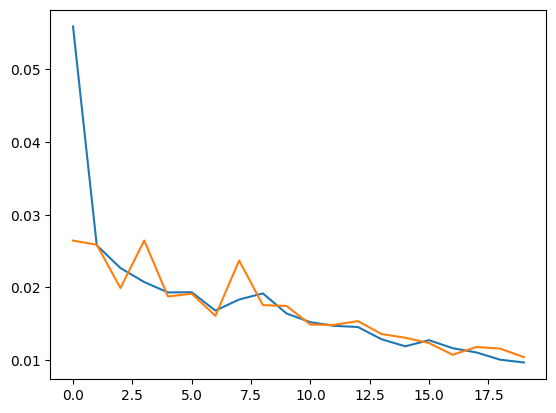

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


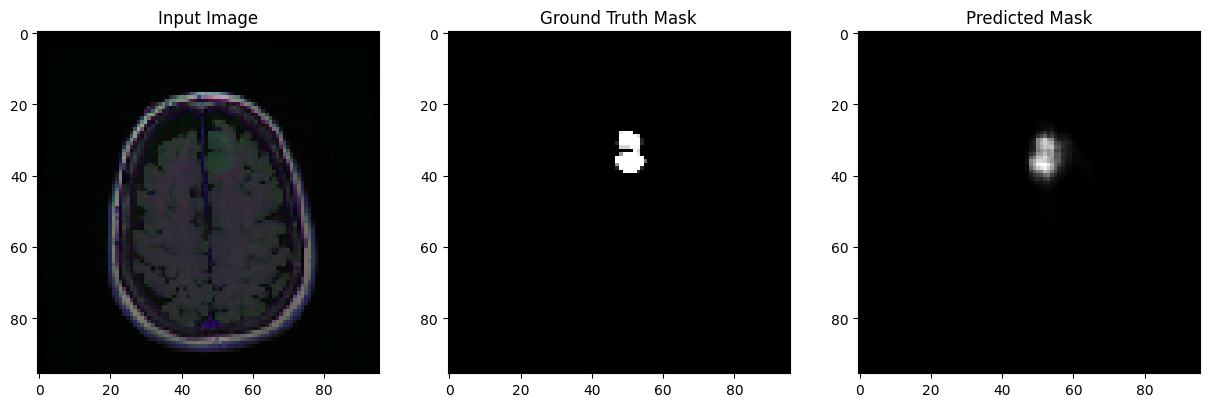

In [ ]:
import random

i = random.randint(0, len(X_val)-1)
test_img = X_val[i]
ground_truth = y_val[i]

pred_mask = model.predict(np.expand_dims(test_img, 0))[0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(test_img)

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth.squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


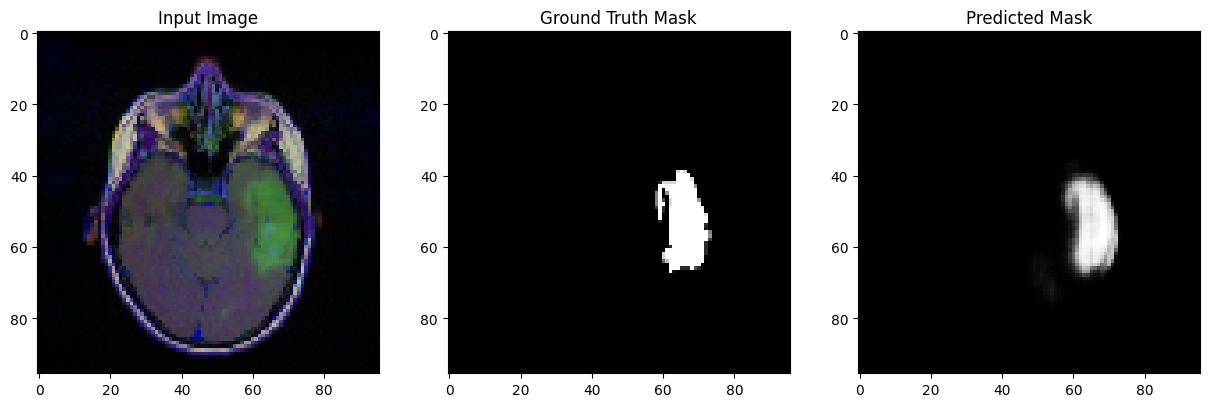

In [ ]:
import random

i = random.randint(0, len(X_val)-1)
test_img = X_val[i]
ground_truth = y_val[i]

pred_mask = model.predict(np.expand_dims(test_img, 0))[0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(test_img)

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth.squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.show()


In [ ]:
model.save("brain_tumor_unet.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
model.save("/content/drive/MyDrive/brain_tumor_unet.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gradio


In [ ]:

import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

model = load_model("/content/brain_tumor_unet.h5", compile=False)
IMG_HEIGHT, IMG_WIDTH = 96, 96

# Define prediction function
def predict_mask(img):
    try:
        img = img.convert("RGB")
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        pred_mask = model.predict(img_array)[0].squeeze()
        mask = (pred_mask > 0.5).astype(np.uint8) * 255
        return Image.fromarray(mask)
    except Exception as e:
        return f"❌ Error: {e}"

# Gradio Interface
demo = gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="pil", label="Upload MRI Image"),
    outputs="image",
    title="🧠 Brain Tumor Segmentation",
    description="Upload an MRI scan to visualize the predicted tumor region."
)

demo.launch(share=True)



FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/brain_tumor_unet.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)